## Helper functions

-- Sys version -- 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
importing Jupyter notebook from interaction_zone.ipynb
-- Sys version -- 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]
importing Jupyter notebook from helper_functions.ipynb
-- Sys version -- 3.8.0 (v3.8.0:fa919fdf25, Oct 14 2019, 10:23:27) 
[Clang 6.0 (clang-600.0.57)]


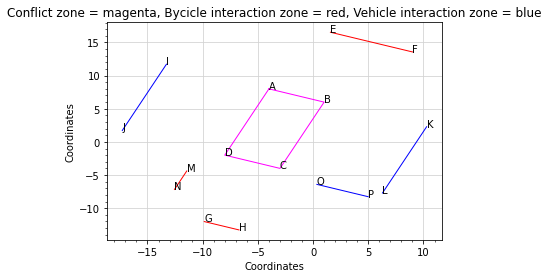

In [1]:
import io
import sys
import csv
import math
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as sklearn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from datetime import datetime
from sklearn import preprocessing 
from mat4py import loadmat
from scipy.spatial import distance
from itertools import accumulate
from matplotlib import animation
from matplotlib.colors import from_levels_and_colors


print('-- Sys version --', sys.version)

# My custom imports
import import_ipynb
import interaction_zone


In [2]:
INTERACTION_ZONE_1_LENGTH = 10

### Data

In [3]:
def getFeatures(instance):
    id = instance['ID']
    t = instance['DateTime']
    ts = np.ravel(instance['Sec']) # Array of timestamps?? Example: 1504545880.957 = Monday, September 4, 2017 5:24:40.957 PM
    x = np.array(instance['Xcoord'])
    y = np.ravel(instance['Ycoord'])
    v = np.ravel(instance['Speed']) # Speed at every coordinate (x, y) (km/h)
    type = instance['AgentType'] # Type 2 = car and 1 = bicycle?
    # estimate = np.ravel(instance['Estimate']) # Don't use!
    # csv = instance['csvFile'] # Don't use!
    
    # Time difference based on ts
    timeDiffWithOneLessValue = np.diff(ts) # time difference between coordinates in Seconds
    timeDiff = np.insert(timeDiffWithOneLessValue, 0, [0], axis=0) # Seconds

    # Distance in meters
    # distance_m = (v*10/36) * timeDiff # Meters
    
    # Distance travelled between timestamps
    distance_m = []
    
    for index, x_start in enumerate(x):

        if index < len(x)-1:
            y_start = x[index]
            x_end = x[index+1]
            y_end = x[index+1]
    
            start = np.array([x_start, y_start])
            end = np.array([x_end, y_end])
    
            dist = distance.euclidean(start, end)
            distance_m.append(dist)
   
    
    return id, t, ts, x, y, v, type, timeDiff, distance_m


### General

In [4]:
def averageList(lst): 
    average = sum(lst) / len(lst)
    return average

### Manually define the conflict zone

In [5]:
def getConflictZoneCoordinates():
    A = [-4, 8]
    B = [1, 6]
    C = [-3, -4]
    D = [-8, -2]
    
    return A, B, C, D


def drawConflictZone():
    A, B, C, D = getConflictZoneCoordinates()
    
    plt.text(A[0], A[1], 'A')  # plot x and y using blue circle markers
    plt.text(B[0], B[1], 'B')
    plt.text(C[0], C[1], 'C')
    plt.text(D[0], D[1], 'D')
    
    plt.plot([A[0], B[0], C[0], D[0], A[0]], [A[1], B[1], C[1], D[1], A[1]], color='magenta', linewidth=1)


### Define interaction zones

In [6]:
def getCenterOfAB():
    A, B, C, D = getConflictZoneCoordinates()
    
    X_coordinate_of_AB_center = (A[0] + B[0])/2
    Y_coordinate_of_AB_center = (A[1] + B[1])/2
    
    center = [X_coordinate_of_AB_center, Y_coordinate_of_AB_center]
    return center

def getCenterOfCD():
    A, B, C, D = getConflictZoneCoordinates()
    
    X_coordinate_of_CD_center = (C[0] + D[0])/2
    Y_coordinate_of_CD_center = (C[1] + D[1])/2
    
    center = [X_coordinate_of_CD_center, Y_coordinate_of_CD_center]
    return center


In [7]:
def getCenterOfAD():
    A, B, C, D = getConflictZoneCoordinates()
    
    X_coordinate_of_AD_center = (A[0] + D[0])/2
    Y_coordinate_of_AD_center = (A[1] + D[1])/2
    
    center = [X_coordinate_of_AD_center, Y_coordinate_of_AD_center]
    return center

def getCenterOfBC():
    A, B, C, D = getConflictZoneCoordinates()
    
    X_coordinate_of_BC_center = (B[0] + C[0])/2
    Y_coordinate_of_BC_center = (B[1] + C[1])/2
    
    center = [X_coordinate_of_BC_center, Y_coordinate_of_BC_center]
    return center


### Coordinates

In [8]:
# ----- instances as array ----- 

def getMaxMinXCoordinate(instances):
    maxXCoordinate = 0
    minXCoordinate = 10000000000

    for i, instance in enumerate(instances):
        
        xCoordinateMax = max(instances[i]['Xcoord'])[0]
        xCoordinateMin = min(instances[i]['Xcoord'])[0]
        
        if (maxXCoordinate < xCoordinateMax):
            maxXCoordinate = xCoordinateMax
            
        if (minXCoordinate > xCoordinateMin):
            minXCoordinate = xCoordinateMin
        
    return maxXCoordinate, minXCoordinate


def getMaxMinYCoordinate(instances):
    maxYCoordinate = 0
    minYCoordinate = 10000000000

    for i in instances:
        yCoordinateMax = max(instances[i]['Ycoord'])[0]
        yCoordinateMin = min(instances[i]['Ycoord'])[0]
        
        if (maxYCoordinate < yCoordinateMax):
            maxYCoordinate = yCoordinateMax
            
        if (minYCoordinate > yCoordinateMin):
            minYCoordinate = yCoordinateMin
            
    return maxYCoordinate, minYCoordinate




In [9]:
# ----- instances as dictionary ----- 
# Id is the instance key

def getMaxMinXCoordinateForInstancesAsDictionary(instances):
    maxXCoordinate = 0
    minXCoordinate = 10000000000

    print(' xxx ', type(instances))
    
    for key in instances:
        xCoordinateMax = max(instances[key]['Xcoord'])[0]
        xCoordinateMin = min(instances[key]['Xcoord'])[0]
        
        if (maxXCoordinate < xCoordinateMax):
            maxXCoordinate = xCoordinateMax
            
        if (minXCoordinate > xCoordinateMin):
            minXCoordinate = xCoordinateMin
        

    return maxXCoordinate, minXCoordinate



def getMaxMinYCoordinateForInstancesAsDictionary(instances):
    maxYCoordinate = 0
    minYCoordinate = 10000000000

    for key in instances:
        yCoordinateMax = max(instances[key]['Ycoord'])[0]
        yCoordinateMin = min(instances[key]['Ycoord'])[0]
        
        if (maxYCoordinate < yCoordinateMax):
            maxYCoordinate = yCoordinateMax
            
        if (minYCoordinate > yCoordinateMin):
            minYCoordinate = yCoordinateMin
     
    return maxYCoordinate, minYCoordinate


### Timestamps

In [10]:
def getAllTimeSteps(instances):
    allTimeStamps = []

    for i in instances:
        timeStamps = np.ravel(instances[i]['Sec'])
        allTimeStamps.extend(timeStamps)
     
    allTimeStamps.sort()
    return allTimeStamps

def findIndexOfTimeStamp(instance, timeStamp):
    timeStamps = np.ravel(instance['Sec'])

    try:
        index = timeStamps.tolist().index(timeStamp)
        return index
    
    except:
        return None


### Plot

In [11]:
# ---- Plot instances as dictionary ----


## TODO: Use in data analysis

# Set threshold of speed less than speed_treshold km/h 
def didAgentsSpeedLower(speedOverTime, speed_treshold = 5):
    for index, speed in enumerate(speedOverTime):
        if (index != 0):
            if speed <= speed_treshold :
                return True, index # returns also at what moment the speed dropped
    return False, None


def plotTrajectories(instances, showSpeedChange=False, speed_treshold=10):
    # Create a figure
    plt.figure()
    plt.title('Trajectories')
    
    plt.xlabel('X coordinates')
    plt.ylabel('Y coordinates')
    
    
    green = '#00cc00'
    blue = '#33ccff'
    red = '#FF0000'

    # For each instance
    for key in instances:
        instance = instances[key] 

        id, t, ts, x, y, v, type, timeDiff, distance_m = getFeatures(instance)

        # Bicycle
        if (type == 1):
            plt.plot(x, y, color=green, linewidth=0.5, label='Cyclist {}'.format(key))
            # Start of the trajectory is represented by o
            plt.plot(x[1], y[1], color=green, marker='o', markersize=4,
                     label='Cyclist {}'.format(key), fillstyle='none')
            # End of the trajectory is represented by x
            plt.plot(x[-1], y[-1], color=green, marker='x', markersize=4,
                     label='Cyclist {}'.format(key), fillstyle='none')
            
            if (showSpeedChange == True):
                didSpeedLower, atTimeStep = didAgentsSpeedLower(v, speed_treshold)
        
                if didSpeedLower == True:
                    print("Cyclist's speed lowered to", speed_treshold, "or less km/h! (id: ", id, ')')
                    plt.plot(x[atTimeStep], y[atTimeStep], color=red, marker='v', markersize=4,
                     label='Cyclist {}'.format(key), fillstyle='none')
                    
                
                    
                

        # Car
        elif (type == 2):
            plt.plot(x, y, color=blue, linewidth=0.5, label='Car {}'.format(key))
            plt.plot(x[1], y[1], color=blue, marker='o', markersize=4,
                     label='Car {}'.format(key), fillstyle='none')
            plt.plot(x[-1], y[-1], color=blue, marker='x', markersize=4,
                     label='Car {}'.format(key), fillstyle='none')
            
            if (showSpeedChange == True):
                didSpeedLower, atTimeStep = didAgentsSpeedLower(v, speed_treshold)

                if didSpeedLower == True:
                    print("Car's speed lowered to", speed_treshold, "or less km/h! (id: ", id, ')')
                    
                    plt.plot(x[atTimeStep], y[atTimeStep], color=red, marker='v', markersize=4,
                     label='Car {}'.format(key), fillstyle='none')

        else:
            print('-- Unknown agent type! --')

    # Create a plot with legend
    green_patch = mpatches.Patch(color=green, label='Bicycles')
    blue_patch = mpatches.Patch(color=blue, label='Vehicles')
    plt.legend(handles=[green_patch, blue_patch])
    plt.grid(b=True, color='#D3D3D3')
    
    # TODO: interaction_zone.drawInteractionAndConflictZones()

    plt.show()


### Animations

In [12]:
def animateTrajectories(instances, index=0, name_suffix='', saveAsVideo=True, showPlot=True):

    print('Number of instances interacting (1 car + bicycles)', len(instances))
    print('Graph index: ', index)

    green = '#00cc00' # Cyclist
    blue = '#33ccff' # Car
    
    maxX, minX = getMaxMinXCoordinateForInstancesAsDictionary(instances)
    maxY, minY = getMaxMinYCoordinateForInstancesAsDictionary(instances)
    
    #if showPlot == True:
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(minX, maxX), ylim=(minY, maxY))
    plt.grid(b=True, color='#D3D3D3')
    interaction_zone.drawInteractionAndConflictZones()

    instance_array = []
    

    for key in instances:
        instance = instances[key] 
        instance_array.append(instance)
    
    lines = []
    
    # Let's cretae a line for each instance who interacted
    for i in range(len(instance_array)):
        
        instance = instance_array[i]
        id, t, ts, x, y, v, type, timeDiff, distance_m = getFeatures(instance)
        
        line_color = green if type == 1 else blue
        
        instance['LastIndex'] = 0
        
        line, = ax.plot([], [], line_color, lw=1)
        lines.append(line)
        
    
    
    def init():
        i = 0
        while i < len(instance_array):
            lines[i].set_data([], [])
            i+=1

        return lines

    # Gets input timestamp from frames
    def animate(timestamp):        
        n=0
        while n < len(lines):
            
            formattedTs =  datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
            plt.title(formattedTs)
            
            index = findIndexOfTimeStamp(instance_array[n], timestamp)
           
            
            if (index != None):
                instance_array[n]['LastIndex'] = index
                
            
            currentIndex = instance_array[n]['LastIndex']

            x = instance_array[n]['Xcoord'][:currentIndex]
            y = instance_array[n]['Ycoord'][:currentIndex]
            
            lines[n].set_data(x, y)
            n+=1
            
        return lines


    timeSteps = getAllTimeSteps(instances)
    
    # Call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, func=animate, init_func=init, frames=timeSteps, interval=100, blit=True)

    if saveAsVideo == True:
        video_name = 'animation_{}_{}.mp4'.format(name_suffix, index)
        anim.save(video_name, fps=30, extra_args=['-vcodec', 'libx264'])

    if showPlot == True:
        plt.show()
